In [17]:
import joblib
import numpy as np
import pandas as pd
import torch

import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from models.MLP import MLP
import data_processing as dp
import model_evaluation as me

In [8]:
####################
# LOADING THE DATA #
####################
SUBJECTS = ['HH']
SCENES = ['FlatWalkStraight', 'FlatWalkCircular', 'FlatWalkStatic']
TRIALS = ('all')

gait_cycles = dp.read_gait_cycles(SUBJECTS, SCENES, TRIALS)

Reading BW jogging_1.csv
Reading BW jogging_2.csv
Reading BW jogging_3.csv
Reading BW jogging_4_badForcePlate.csv
Reading Bw stop FW walking_1_badForcePlate.csv
Reading Bw stop FW walking_2_badForcePlate.csv
Reading Bw stop FW walking_3.csv
Reading Bw stop FW walking_4_badForcePlate.csv
Reading Bw stop FW walking_5.csv
Reading BW walking_1.csv
Reading BW walking_2.csv
Reading BW walking_3.csv
Reading BW walking_4.csv
Reading BW walking_5_badForcePlate.csv
Reading BW walking_6_badForcePlate.csv
Reading BW-L walking_1.csv
Reading BW-L walking_2.csv
Reading BW-L walking_3_badForcePlate.csv
Reading BW-L walking_4_badForcePlate.csv
Reading BW-R walking_1.csv
Reading BW-R walking_2.csv
Reading BW-R walking_3.csv
Reading BW-R walking_4.csv
Reading FW jogging_1.csv
Reading FW jogging_2.csv
Reading FW jogging_3.csv
Reading FW jogging_4.csv
Reading FW jogging_5_badForcePlate.csv
Reading FW jogging_6.csv
Reading FW stop 180 FW walking_2_badForcePlate.csv
Reading FW stop 180 FW walking_3.csv
Readi

In [9]:
##############################################
# LEFT VS. RIGHT FOOT -> MAIN VS. OTHER FOOT #
##############################################
df_l, df_r = dp.homogenize(gait_cycles)
df_homogenous = pd.concat([df_l, df_r])

In [10]:
#############
# FILTERING #
#############
df_filtered = dp.filter(df_homogenous)

df_filtered.groupby(['trial'])['trial'].count()

trial
BW jogging_1.csv                             23
BW jogging_2.csv                             25
BW jogging_3.csv                             24
BW jogging_4_badForcePlate.csv               23
BW walking_1.csv                             77
                                           ... 
Sidestepping normal_6_badForcePlate.csv     150
Sit-to-stand_badForcePlate.csv             1354
Sitting_badForcePlate.csv                   370
Squat.csv                                   585
Standing.csv                                987
Name: trial, Length: 105, dtype: int64

In [11]:
############################
# FEATURE/LABEL EXTRACTION #
############################
# Features
X = dp.extract_features(df_filtered)

# Labels
Y = df_filtered[['Fx', 'Fy', 'Fz', 'Tz']]

# Strata
strata = df_filtered['trial']

In [12]:
######################
# CONVERT TO TENSORS #
######################
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.to_numpy().reshape((-1, 4)), dtype=torch.float32)

In [13]:
####################
# TRAIN-TEST SPLIT #
####################
# Make the same stratified split for X, Y and strata
(X_full_train,      X_test, 
 Y_full_train,      Y_test, 
 strata_full_train, strata_test) = train_test_split(X_tensor, Y_tensor, strata, test_size=0.2, random_state=42, stratify=strata)

In [ ]:
DIR = '../results/20240523-204855'

In [14]:
DIR = 'results/' + time.strftime("%Y%m%d-%H%M%S/", time.localtime())

###############
# PERFORM PCA #
###############
X_pc_full_train, X_pc_test = dp.perform_pca(X_full_train, X_test, DIR)

Performance on the test set:
NRMSE = 0.0659
r = 0.9271290573489783


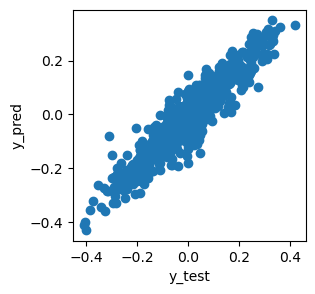

In [18]:
################
# Fx REGRESSOR #
################
Fx_regressor = MLP([42])
Fx_regressor.train_(X_pc_full_train, Y_full_train[:, 0].reshape(-1, 1))

# Evaluate the model
Fx_regressor.eval()
Fx_pred = Fx_regressor(X_pc_test)
me.print_metrics(Y_test[:, 0].reshape(-1, 1), Fx_pred)

Performance on the test set:
NRMSE = 0.0539
r = 0.9512165415283007


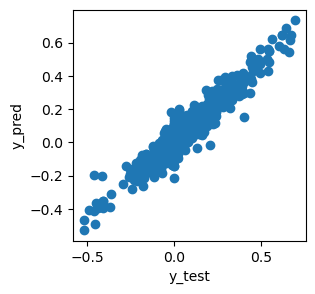

In [20]:
################
# Fy REGRESSOR #
################
Fy_regressor = MLP([42])
Fy_regressor.train_(X_pc_full_train, Y_full_train[:, 1].reshape(-1, 1))

# Evaluate the model
Fy_regressor.eval()
Fy_pred = Fy_regressor(X_pc_test)
me.print_metrics(Y_test[:, 1].reshape(-1, 1), Fy_pred)

Performance on the test set:
NRMSE = 0.0365
r = 0.990316161100608


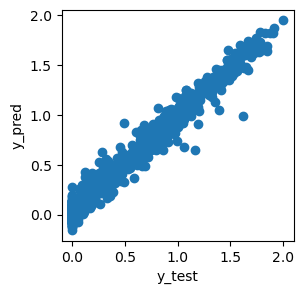

In [21]:
################
# Fz REGRESSOR #
################
Fz_regressor = MLP([42])
Fz_regressor.train_(X_pc_full_train, Y_full_train[:, 2].reshape(-1, 1))

# Evaluate the model
Fz_regressor.eval()
Fz_pred = Fz_regressor(X_pc_test)
me.print_metrics(Y_test[:, 2].reshape(-1, 1), Fz_pred)

Performance on the test set:
NRMSE = 0.0897
r = 0.8744699117220396


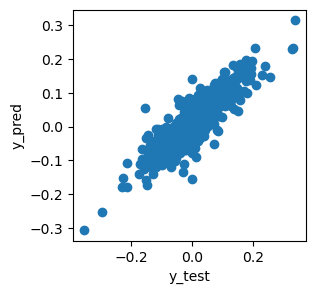

In [22]:
################
# Tz REGRESSOR #
################
Tz_regressor = MLP([50])
Tz_regressor.train_(X_pc_full_train, Y_full_train[:, 3].reshape(-1, 1))

# Evaluate the model
Tz_regressor.eval()
Tz_pred = Tz_regressor(X_pc_test)
me.print_metrics(Y_test[:, 3].reshape(-1, 1), Tz_pred)